# Exploratory analysis of graph

This notebook contains a function to explore the graph we created.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import scipy

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'

In [2]:
from sklearn.cluster import KMeans
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    diags = np.diag(np.sum(adjacency,axis=0))
    if not(normalize):
        return diags - adjacency
    else:
        with np.errstate(divide='ignore'):
            diags_sqrt = 1.0/np.sqrt(diags)
        diags_sqrt[np.isinf(diags_sqrt)] = 0
        
        return np.identity(adjacency.shape[0]) - diags_sqrt.dot(adjacency).dot(diags_sqrt)
    
# the return np.linalg.eig(laplacian) seemed to give an error (eigenvalues normalized above 1)
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    #return np.linalg.eig(laplacian)
    lamb, U = np.linalg.eigh(laplacian)
    return lamb , U

def plot_eigenvalues(adjacency):
    laplacian = compute_laplacian(adjacency, normalize = True)
    lam, U = spectral_decomposition(laplacian)
    limit = 0.15
    print (f'{np.count_nonzero(lam < limit)} Eigenvalues below {limit}')
    plot_y = lam[:]
    plt.scatter(range(len(plot_y)), plot_y)
    plt.plot(range(len(plot_y)), [limit] * len(plot_y), 'r-')
    plt.show()
           
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool, adjacency = None):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.lam = None
        
    def fit_predict(self, adjacency = None):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.U = U[:,:self.n_classes]
        if self.normalize:
            t = np.sqrt((self.U**2).sum(axis=1)).reshape(len(adjacency),1)
            self.U /= t
        print(self.n_classes)
        return KMeans(n_clusters = self.n_classes).fit_predict(self.U)
    
def laplacian_eigenmaps(adjacency, dim: int, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    laplacian = compute_laplacian(adjacency, normalize=normalize)
    lamb_all, U_all = spectral_decomposition(laplacian)
    coords = U_all[:,1:dim+1]
    return coords

def moment_1(arr):
    return np.mean(arr)
def moment_2(arr):
    return np.sum(np.power(arr,2)) / arr.shape[0]

In [11]:
def poisson(k, a, lamb):
    return a * (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)

def poisson_approx(k, a, lamb):
    return a*np.exp(-(k-lamb)**2/(2*lamb))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def power(x,a,gamma,k0):
    return a* x**(gamma-1) * x**(-gamma)

def graph_exploratory_analysis(graph, graph_type="ratings"):
    # Basic stats
    print('Number of nodes: {}, Number of edges: {}'. format(graph.number_of_nodes(), graph.number_of_edges()))
    # Number of connected components
    print('Number of connected components: {}'. format(nx.number_connected_components(graph)))
    # Diameter
    if nx.number_connected_components(graph) == 1:
        print('Diameter of the graph: {}'.format(nx.diameter(graph)))
    # Clustering coefficient
    print('Clustering coefficient: {}'.format(nx.average_clustering(graph)))
    # Degree distribution 
    degrees = [d for n,d in graph.degree()]
    
    plt.figure(figsize = [3.8,3.5])
    entries, bin_edges, patches = plt.hist(degrees, bins = 21, color = 'xkcd:dark gray', label = 'Degrees dist.')
    bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mean = np.mean(degrees) #sum(bin_middles * entries) / len(bin_middles)
    sigma = np.var(degrees) #  sum(entries*(bin_middles-mean)**2)/ len(bin_middles)
    
    popt_gauss,pcov_gauss = scipy.optimize.curve_fit(gaus, bin_middles, entries, p0=[np.max(entries), mean,sigma])
    popt_poiss2,pcov_poiss2 = scipy.optimize.curve_fit(poisson_approx, bin_middles, entries, p0=[np.max(entries), mean])
  #  popt_power,pcov_power = scipy.optimize.curve_fit(power, bin_middles[np.argmax(entries):], entries[np.argmax(entries):], p0=[np.max(entries), mean,10])
    
    x_plot = np.linspace(np.min(bin_edges), np.max(bin_edges),100)
    plt.plot(x_plot,gaus(x_plot,*popt_gauss),'-',c = 'xkcd:orange', label='Normal dist. fit')
    plt.plot(x_plot,poisson_approx(x_plot,*popt_poiss2),'-',c = 'xkcd:green', label='Poisson dist. fit')
   # plt.plot(x_plot,power(x_plot,*popt_power),'-',c = 'xkcd:red', label='Power dist. fit')
    plt.legend()
   # plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.xlim(np.min(bin_edges), np.max(bin_edges))
    plt.ylim(top = 1.4 * np.max(entries))
    plt.tight_layout()
    plt.savefig(f'{RESULT_PATH}{graph_type}_graph_degree_distribution.eps')
    plt.savefig(f'{RESULT_PATH}{graph_type}_graph_degree_distribution.png', dpi = 300)
    plt.show()
    
    plt.loglog(bin_middles, entries,'o')
    plt.loglog(x_plot,gaus(x_plot,*popt_gauss),'-',c='xkcd:orange',label='fit')
    plt.title("Degree distribution Log-Log")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.savefig(RESULT_PATH+'movie_'+graph_type+'_graph_degree_distribution_loglog.eps')
    plt.savefig(RESULT_PATH+'movie_'+graph_type+'_graph_degree_distribution_loglog.png')
    plt.show()
    
    print(f'mean degree', np.mean(degrees))
    print(f'2nd moment of degrees:', np.sum(np.power(degrees,2)) / len(degrees))
    
    # Centrality
    centrality = list(nx.degree_centrality(graph).values())
    print('Mean degree centrality of nodes: {}'.format(np.mean(centrality)))
    
    # largest connected component
    Gc = max(nx.connected_component_subgraphs(graph), key=len)
    print(f'Diameter of largest connected component: {nx.diameter(Gc)}')
    
    print(f'Average clustering: {nx.average_clustering(graph)}')
      
    print()
    
    print('Eigenvalue distribution of the graph')
    plot_eigenvalues(adjacency)
    
    coords2D = laplacian_eigenmaps(adjacency, 2, normalize = True)
    
    print('Laplacian Eigenmaps of the Graph')
    plt.scatter(coords2D[:, 0], coords2D[:, 1])
    

## Movie Ratings Graph

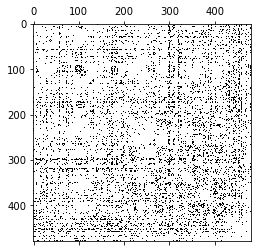

In [12]:
adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

Number of nodes: 480, Number of edges: 14452
Number of connected components: 6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Clustering coefficient: 0.2837056950074333


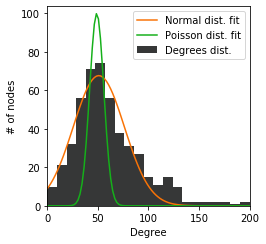

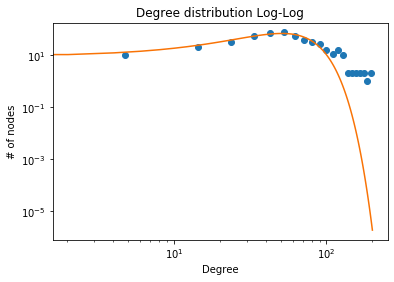

mean degree 60.21666666666667
2nd moment of degrees: 4716.8875
Mean degree centrality of nodes: 0.12571329157967986
Diameter of largest connected component: 4
Average clustering: 0.2837056950074333

Eigenvalue distribution of the graph
1 Eigenvalues below 0.15


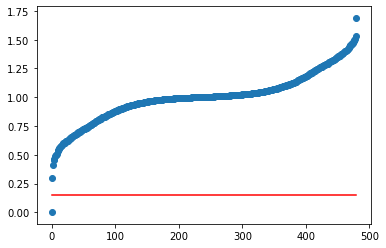

Laplacian Eigenmaps of the Graph


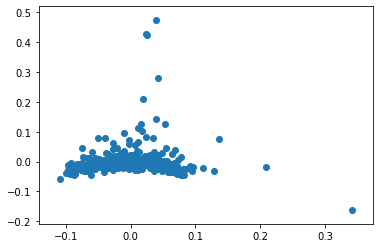

In [13]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph, 'movie_rating')

## Movie Feature Graph

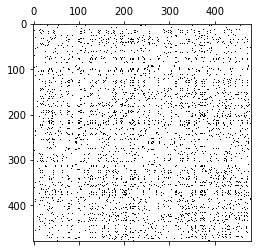

In [14]:
adjacency = np.loadtxt(GENERATED_PATH+'movie_features_adj.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Number of nodes: 480, Number of edges: 7889
Number of connected components: 3
Clustering coefficient: 0.5915343815457017


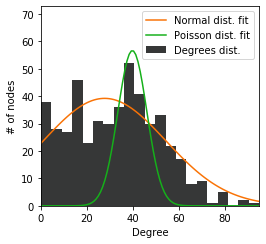

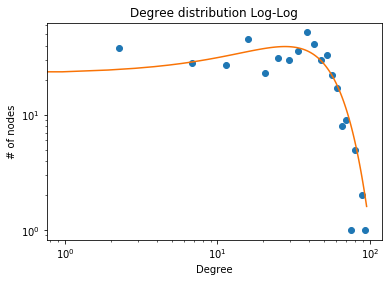

mean degree 32.87083333333333
2nd moment of degrees: 1450.875
Mean degree centrality of nodes: 0.06862386917188587
Diameter of largest connected component: 6
Average clustering: 0.5915343815457017

Eigenvalue distribution of the graph
8 Eigenvalues below 0.15


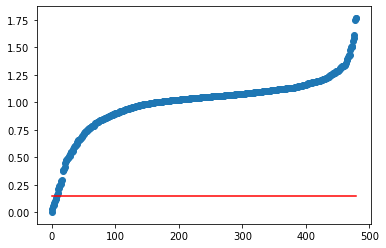

Laplacian Eigenmaps of the Graph


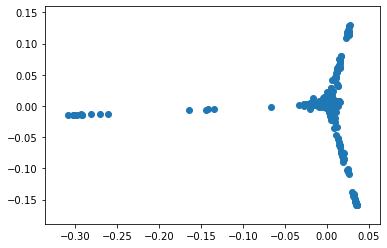

In [15]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph, 'movie_feature')

## User Graph

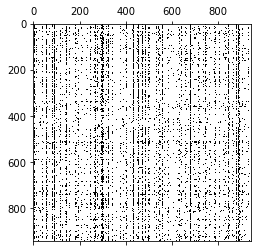

In [16]:
adjacency = np.loadtxt(GENERATED_PATH+'user_ratings_adj.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

Number of nodes: 943, Number of edges: 106640
Number of connected components: 1
Diameter of the graph: 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Clustering coefficient: 0.5763967938396763


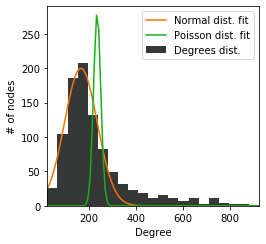

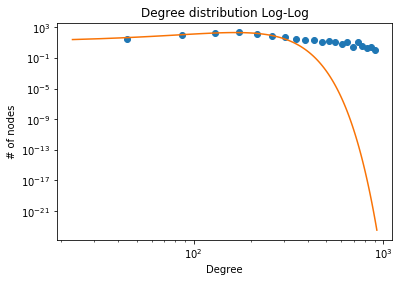

mean degree 226.17179215270414
2nd moment of degrees: 73040.30752916225
Mean degree centrality of nodes: 0.24009744389883667
Diameter of largest connected component: 3
Average clustering: 0.5763967938396763

Eigenvalue distribution of the graph
23 Eigenvalues below 0.15


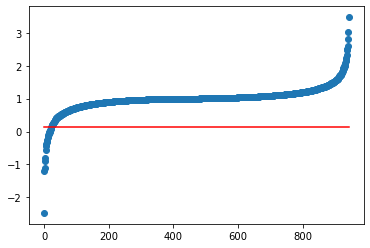

Laplacian Eigenmaps of the Graph


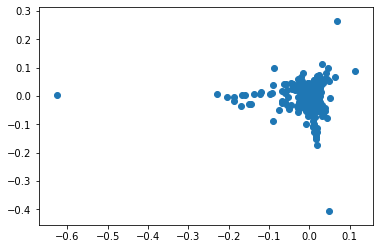

In [17]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph,'user_rating')